# Remarks

* Data normalization
    * Mobilenet expects data from -1 to 1
        * Normalize Input Data or Include in Model
        * TFLite Conversion must fit according to decision
    * Ground Truth Data: for better inspection Data multiplied by 80. Undo the change in the Data Input Pipeline
* Overview in Tutorials:
    * tf.function
* Idea

# Libraries

In [2]:
#!for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done

import tensorflow as tf
import numpy as np
import os
import time
from datetime import datetime
import sys
import matplotlib.pyplot as plt
import argparse

import DataProcessing.data_processing as data_processing
import Nets.backbones as backbones
import Nets.features as features
import Nets.losses as losses
import Nets.metrics as metrics
import Nets.visualize as visualize
import Nets.tools as tools


os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

#np.set_printoptions(threshold=sys.maxsize)

# Parser

In [3]:
parser = argparse.ArgumentParser()

parser.add_argument('--model', type=str, required=False, default=None)
parser.add_argument('--data', type=str, required=False, default=None)

parser.add_argument('--bs', type=int, required=False, default=None)
parser.add_argument('--idx', type=int, required=False, default=None)
parser.add_argument('--epoch', type=int, required=False, default=None)
parser.add_argument('--noise', type=float, required=False, default=None)

parser.add_argument('--train_model', action='store_true', default=False)
parser.add_argument('--cache', action='store_true', default=False)
parser.add_argument('--save', action='store_true', default=False)
parser.add_argument('--sigmoid', action='store_true', default=False)
parser.add_argument('--focal', action='store_true', default=False)

parser.add_argument('--beta_upper', type=float, required=False, default=None)
parser.add_argument('--gamma', type=float, required=False, default=None)
parser.add_argument('--alpha', type=float, required=False, default=None)

file_name = None
try:
    file_name = __file__
except:
    print("Jupyter Notebook")
       
if file_name is None:
    args = parser.parse_args("")
    args.train_model = True
    args.cache = True
    #args.save = True
    args.save = True
    args.sigmoid = False
    args.focal = True
else:    
    args = parser.parse_args()

Jupyter Notebook


# Options

In [15]:
# Generall Parameters
# MODEL= 'SGED_FOCAL_LOSS_0.5_g2_a2' if args.model is None else args.model
MODEL = "TEST"
DATA= 'SceneNetFloorTiledTextureRandom' if args.data is None else args.data
TRAIN_DS ='Train'
TEST_DS = 'Test'
HALF = True

# Dataset Loading Parameters
# IMG_SIZE_HEIGHT = 1280
# IMG_SIZE_WIDTH = 720
IMG_SIZE = (1280, 720)
IMG_SIZE_MODEL = (640, 360)
NUM_CLASSES = 1
MAX_IMG_TRAIN = 1500
MAX_IMG_TEST = 300
SEED = None
BATCH_SIZE = 3 if args.bs is None else args.bs
CACHE = args.cache
NOISE_STD = 0.0 if args.noise is None else args.noise

# Model Parameters
BACKBONE = "MobileNetV2"
output = 5
BACKBONE_OUTPUT = [1,2,3,output]
BACKBONE_WEIGHTS = "imagenet"
ALPHA = 0.35
FINE_TUNING = False
FINE_TUNE_EPOCHS = 10
TRAINABLE_IDX = 0 if args.idx is None else args.idx # (3-1), as indexing starts at 0
EPOCHS = 10 if args.epoch is None else args.epoch
SAVE = args.save
TRAIN_MODEL = args.train_model

#Model Callback
MODEL_SAVE_EPOCH_FREQ = 5
DEL_OLD_CHECKPOINTS = False
TENSORBOARD = False
DEL_OLD_TENSORBOARD = True

# LOSS
weighted_multi_label_sigmoid_edge_loss = args.sigmoid
focal_loss = args.focal

beta_upper = 0.5 if args.beta_upper is None else args.beta_upper
beta_lower = 1.0 - beta_upper
gamma=2.0 if args.gamma is None else args.gamma 
alpha=2.0 if args.alpha is None else args.alpha
class_weighted = True
weighted_beta=True


# All Pixels have been labeled correctly and thus we don't need to account shifted labels 
# and a protection band around the labels for the calculation of the metrics

# In the work of Frey he mentioned that state of the Art ? is 2% of diagonal. 
# He takes 1%, I sugest to take a threshold of 3 Pixels. 
#I don't think that I made more then 3 Pixel mistake in labeling and tracking. Thus this is 0.4%
THRESHOLD_EDGE_WIDTH_REAL = 2

# Data Augmentation:
aug_param = {"contrast_factor": 0.9, "brightness": 0.1, "hue": 0.03, "saturation": 0.9, "gaussian_value": 0.015,
            "value": 0.1, "strength_spot": 0.3, "blur": False, "sigma": 1.0}

#TESTING
test = False
if test:
    EPOCHS = 10
    MAX_IMG_TRAIN = 18
    MAX_IMG_TEST = 3

# Load Dataset, Preprocess Images and Dataset

In [5]:
tf.random.set_seed(SEED)

paths, files = data_processing.path_definitions(HALF, MODEL, DATA, TRAIN_DS, TEST_DS, make_dirs=True)

data_processing.clean_model_directories(paths, DEL_OLD_CHECKPOINTS, DEL_OLD_TENSORBOARD)

if TRAIN_MODEL:
    
    rng = tf.random.Generator.from_seed(123, alg='philox')


    train_ds, img_count_train = data_processing.load_dataset(paths,"TRAIN", IMG_SIZE, IMG_SIZE_MODEL, NUM_CLASSES, HALF, 
                                                             MAX_IMG_TRAIN, noise_std=NOISE_STD, single_class = True)
    train_ds = data_processing.dataset_processing(train_ds, cache=CACHE, shuffle=True, batch_size=BATCH_SIZE, prefetch=True, 
                                                  img_count=img_count_train, augment=True, rng=rng, aug_param=aug_param)


test_ds, img_count_test = data_processing.load_dataset(paths,"TEST", IMG_SIZE, IMG_SIZE_MODEL, NUM_CLASSES, HALF, 
                                                       MAX_IMG_TEST, noise_std=None, single_class = True)
test_ds = data_processing.dataset_processing(test_ds, cache=CACHE, shuffle=False, batch_size=BATCH_SIZE, prefetch=True, 
                                             img_count=img_count_test)

2022-07-26 10:11:39.310566: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-26 10:11:39.310621: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (david-ThinkPad-X1-Yoga-Gen-6): /proc/driver/nvidia/version does not exist
2022-07-26 10:11:39.311357: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The TRAIN Dataset contains 1500 images.
The TEST Dataset contains 300 images.


In [6]:
DATA_REAL = 'RealRed'
TRAIN_REAL = 'Train'
TEST_REAL = 'Test'
TEST_HARD_REAL = 'Test Hard'
IMG_ONLY_REAL = 'Img Only'
BS_REAL = 8

paths_real, files_real = data_processing.path_definitions(HALF, MODEL, DATA_REAL, TRAIN_REAL, TEST_REAL, TEST_HARD_REAL, IMG_ONLY_REAL, make_dirs=False)

test_real_ds, img_count_test_real = data_processing.load_dataset(paths_real,"TEST", IMG_SIZE, IMG_SIZE_MODEL, NUM_CLASSES, HALF, MAX_IMG_TEST, single_class=True)
test_real_ds = data_processing.dataset_processing(test_real_ds, cache=False, shuffle=False, batch_size=BS_REAL, prefetch=False, img_count = img_count_test_real)

TypeError: in user code:

    File "/home/david/SemesterProject/SGED/DataProcessing/data_processing.py", line 149, in None  *
        lambda x: parse_image(x, has_mask, single_class)
    File "/home/david/SemesterProject/SGED/DataProcessing/data_processing.py", line 83, in parse_image  *
        image = tf.io.read_file(img_path)

    TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.


# Model

In [7]:
if weighted_multi_label_sigmoid_edge_loss:
    loss = lambda y_true, y_pred : losses.weighted_multi_label_sigmoid_loss(y_true,y_pred,beta_lower=beta_lower,beta_upper=beta_upper, class_weighted=class_weighted)
elif focal_loss:
    loss = lambda y_true, y_pred : losses.focal_loss_edges(y_true, y_pred, gamma=gamma, alpha=alpha, weighted_beta=weighted_beta,beta_lower=beta_lower,beta_upper=beta_upper, class_weighted=class_weighted)
else:
    raise ValueError("either FocalLoss or WeightedMultiLabelSigmoidLoss must be True")

In [12]:
if TRAIN_MODEL:

    output_dims = (int(IMG_SIZE[0]/2), int(IMG_SIZE[1]/2))
    
    # BACKBONE
    backbone, output_names = backbones.get_backbone(name=BACKBONE,weights=BACKBONE_WEIGHTS,
                                              height=IMG_SIZE[0],width=IMG_SIZE[1],
                                              alpha=ALPHA, output_layer = BACKBONE_OUTPUT, 
                                              trainable_idx=TRAINABLE_IDX)

    # DASPP
    daspp = features.DASPP(backbone.output[-1])

    # Decoder
    decoded = features.decoder(daspp, backbone.output[-1], output_dims=output_dims, NUM_CLASSES=NUM_CLASSES, num_side_filters = 6)
    decoded = tf.image.resize(decoded,(int(IMG_SIZE[0]),int(IMG_SIZE[1])))

    # SIDE FEATURES
    # TODO: Upsampling: Nearest NEIGHBOUR ?
    upsample_side_1 = features.side_feature_SGED(backbone.output[0], output_dims=output_dims ,interpolation="bilinear", name="side1")
    upsample_side_2 = features.side_feature_SGED(backbone.output[1], output_dims=output_dims ,interpolation="bilinear", name="side2")
    upsample_side_3 = features.side_feature_SGED(backbone.output[2], output_dims=output_dims ,interpolation="bilinear", name="side3")

    # TODO: adaptive weight fusion ?
    # CONCATENATE
    side_outputs = [upsample_side_1,upsample_side_2,upsample_side_3,decoded]
    # concat = features.shared_concatenation(side_outputs,NUM_CLASSES)
    # output = features.fused_classification(concat,NUM_CLASSES,name="output")
    output = features.shared_concatenation_fused_classification(side_outputs, NUM_CLASSES, name = "output")
    model = tf.keras.Model(inputs = backbone.input, outputs = output)
    
# model.layers[-1]._name = "output"
#model.summary()

# Compile and Train Model

In [13]:
if TENSORBOARD:
    %load_ext tensorboard
    %tensorboard --logdir /home/david/SemesterProject/Models/CASENet/logs

In [14]:
if TRAIN_MODEL:
    # learning rate schedule
    base_learning_rate = 0.0015
    end_learning_rate = 0.0005
    decay_step = np.ceil(img_count_train / BATCH_SIZE)*EPOCHS
    lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(base_learning_rate,decay_steps = decay_step,end_learning_rate = end_learning_rate, power = 0.9)

    frequency = int(np.ceil(img_count_train / BATCH_SIZE)*MODEL_SAVE_EPOCH_FREQ)+1

    logdir = os.path.join(paths['TBLOGS'], datetime.now().strftime("%Y%m%d-%H%M%S"))
    callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = paths["CKPT"]+ "/ckpt-loss={val_loss:.2f}-epoch={epoch:.2f}-f1={val_f1:.4f}",
                                                    save_weights_only=False,save_best_only=False,monitor="val_f1",verbose=1,save_freq= 'epoch', period=5),
                tf.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1)]

    # compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss=loss,
                  metrics=[metrics.BinaryAccuracyEdges(threshold_prediction=0),
                                      metrics.F1Edges(threshold_prediction=0, threshold_edge_width=0)])

    history = model.fit(train_ds, epochs=EPOCHS, validation_data=test_real_ds, callbacks=callbacks)

NameError: name 'test_real_ds' is not defined

In [10]:
model_ckpt = os.listdir(paths['CKPT'])

f1_max = 0
for ckpt_name in model_ckpt:
    if float(ckpt_name[-4:]) > f1_max:
        f1_max = float(ckpt_name[-4:])
        model_path = paths['CKPT']+"/"+ckpt_name
        
        print(model_path)

custom_objects = {"BinaryAccuracyEdges": metrics.BinaryAccuracyEdges,
                  "F1Edges": metrics.F1Edges,
                  "<lambda>":loss}

model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

/home/david/SemesterProject/Models/SceneNetFloorTiledTextureRandom/TEST/CKPT/ckpt-loss=1281.55-epoch=5.00-f1=0.0673
/home/david/SemesterProject/Models/SceneNetFloorTiledTextureRandom/TEST/CKPT/ckpt-loss=516.06-epoch=5.00-f1=0.2689
/home/david/SemesterProject/Models/SceneNetFloorTiledTextureRandom/TEST/CKPT/ckpt-loss=296.25-epoch=10.00-f1=0.4207


# Plot Results

In [12]:
if TRAIN_MODEL:
    plot_losses = ["loss", "output_loss"]
    plot_metrics = ["output_accuracy_edges", "f1", "recall", "precision"]

    path = os.path.join(paths["FIGURES"],"training.svg")

    visualize.plot_training_results(res=history.history, losses=plot_losses, metrics=plot_metrics, save=SAVE, path=path)

2022-07-12 18:04:34.305700: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


100/100 - 9s - loss: 0.0000e+00 - accuracy_edges: 0.1931 - f1_1: 0.0171 - precision_1: 0.0086 - recall_1: 0.9988 - f1_2: 0.0267 - precision_2: 0.0135 - recall_2: 0.9987 - f1_3: 0.0087 - precision_3: 0.0044 - recall_3: 0.9995 - 9s/epoch - 87ms/step
100/100 - 6s - loss: 0.0000e+00 - accuracy_edges: 0.9349 - f1_1: 0.2350 - precision_1: 0.1342 - recall_1: 0.9420 - f1_2: 0.3607 - precision_2: 0.2218 - recall_2: 0.9652 - f1_3: 0.1495 - precision_3: 0.0809 - recall_3: 0.9816 - 6s/epoch - 61ms/step
100/100 - 7s - loss: 0.0000e+00 - accuracy_edges: 0.9778 - f1_1: 0.4108 - precision_1: 0.2703 - recall_1: 0.8556 - f1_2: 0.6298 - precision_2: 0.4881 - recall_2: 0.8873 - f1_3: 0.3725 - precision_3: 0.2326 - recall_3: 0.9354 - 7s/epoch - 68ms/step
100/100 - 7s - loss: 0.0000e+00 - accuracy_edges: 0.9884 - f1_1: 0.5622 - precision_1: 0.4487 - recall_1: 0.7525 - f1_2: 0.7198 - precision_2: 0.6658 - recall_2: 0.7834 - f1_3: 0.5487 - precision_3: 0.4050 - recall_3: 0.8508 - 7s/epoch - 67ms/step
100/100 

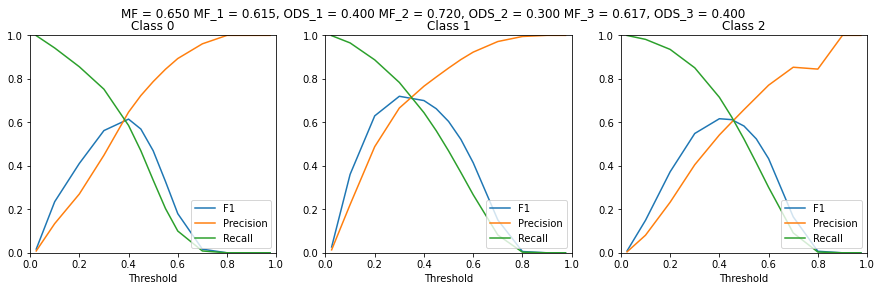

In [13]:
### Maximum F1 Score:
if not TRAIN_MODEL:
    step_width = 0.05
    threshold_range = [0.05,0.95]
    threshold_array = np.arange(threshold_range[0],threshold_range[1]+step_width,step_width)
    threshold_array = np.array([0.025, 0.1, 0.2,0.3,0.4,0.45,0.5,0.55,0.6,0.7,0.8, 0.9, 0.975])

    path_metrics_evaluation_plot = os.path.join(paths["FIGURES"],"threshold_metrics_evaluation_test_ds.svg")
    threshold_f1_max = visualize.plot_threshold_metrics_evaluation_class(model=model, 
                                                                         ds=test_ds,
                                                                         num_classes=NUM_CLASSES,
                                                                         threshold_array=threshold_array, 
                                                                         threshold_edge_width=0, save=SAVE, 
                                                                         path=path_metrics_evaluation_plot)

[[[-3.511419  -2.5736148 -2.6028175]
  [-3.7931197 -3.1134076 -3.0720415]
  [-3.746148  -3.1720433 -3.1513972]
  [-3.7830062 -3.2724838 -3.2840495]
  [-3.8393571 -3.3624978 -3.4053533]
  [-3.8582249 -3.3011878 -3.392455 ]
  [-3.8755705 -3.2376928 -3.3628187]
  [-3.808482  -3.1230345 -3.281244 ]
  [-3.8476484 -3.2851884 -3.4409418]
  [-3.8633652 -3.4116695 -3.5703335]]

 [[-3.7911825 -3.0347815 -3.012602 ]
  [-4.1548004 -3.4988353 -3.4160392]
  [-4.3144784 -3.9275618 -3.8127599]
  [-4.375442  -4.0459137 -3.9596193]
  [-4.467761  -4.181338  -4.118779 ]
  [-4.5287385 -4.179975  -4.1565895]
  [-4.541129  -4.0418057 -4.0621247]
  [-4.447426  -3.8297806 -3.8970137]
  [-4.411437  -3.8206515 -3.910375 ]
  [-4.6932755 -4.3867965 -4.4173265]]

 [[-3.3515308 -2.6544833 -2.751659 ]
  [-3.8181868 -3.2888088 -3.3004675]
  [-3.8825524 -3.4729052 -3.4853396]
  [-3.9927175 -3.6204262 -3.6570778]
  [-4.1026816 -3.723194  -3.7878606]
  [-4.199814  -3.7410736 -3.842642 ]
  [-4.099077  -3.3814073 -3.549988

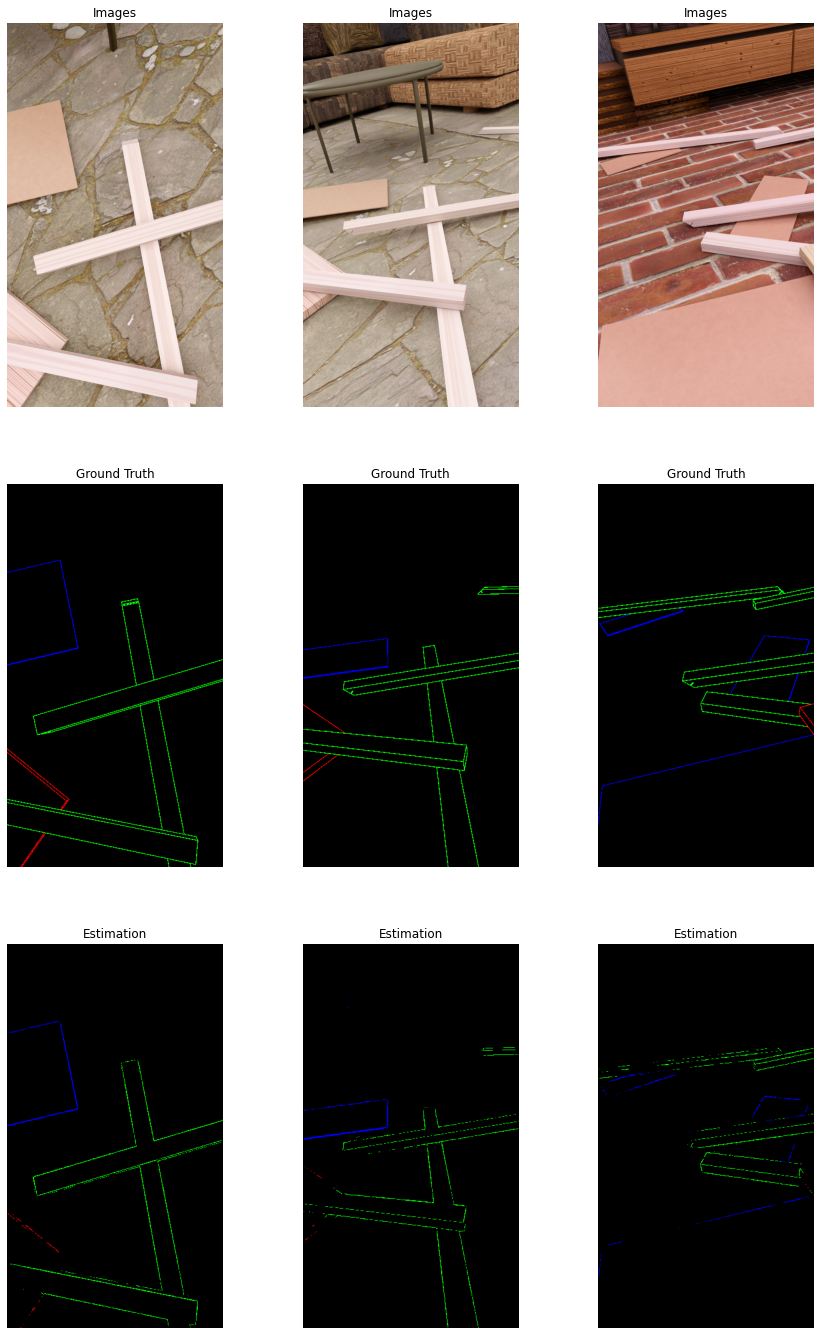

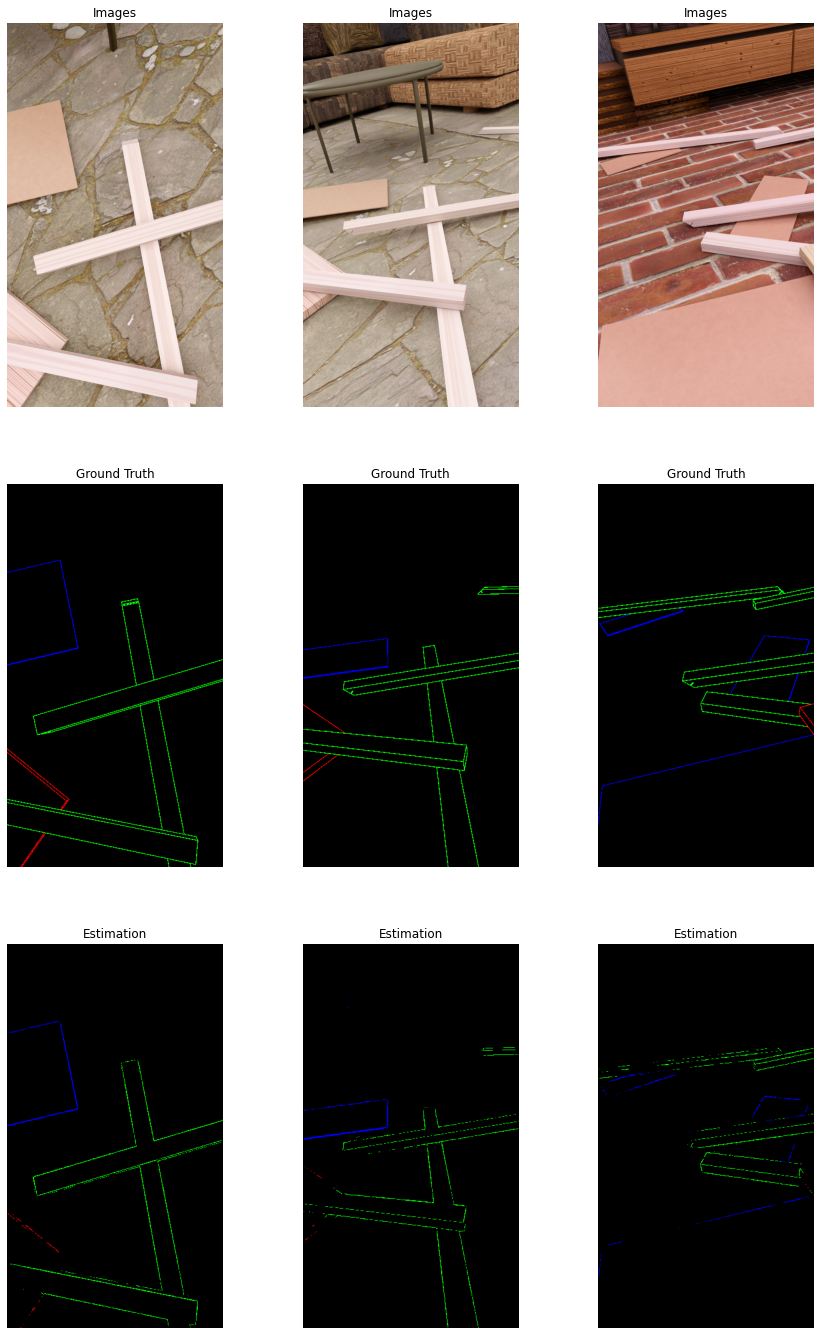

In [17]:
if not TRAIN_MODEL:
    i = 0
    for img, label in test_ds.take(1):
        img, label = img, label

        threshold = 0.5

        predictions = model.predict(img)
        predictions = tools.predict_class_postprocessing(predictions, threshold=threshold)
        

        path = os.path.join(paths["FIGURES"],"img_test_threshold_{}_{}".format(threshold,i))
        visualize.plot_images(images=img, labels=label, predictions=predictions, save=SAVE, path=path, batch_size=3)

        threshold = threshold_f1_max
        path = os.path.join(paths["FIGURES"],"img_test_ods_{}".format(i))
        visualize.plot_images(images=img, labels=label, predictions=predictions, save=SAVE, path=path, batch_size=3)

        i += 1

# Fine Tuning

# Evaluate on Test DS of Real Images

In [ ]:
DATA_REAL = 'RealRed'
TRAIN_REAL = 'Train'
TEST_REAL = 'Test'
TEST_HARD_REAL = 'Test Hard'
IMG_ONLY_REAL = 'Img Only'
BS_REAL = 8

paths_real, files_real = data_processing.path_definitions(HALF, MODEL, DATA_REAL, TRAIN_REAL, TEST_REAL, TEST_HARD_REAL, IMG_ONLY_REAL, make_dirs=False)

test_real_ds, img_count_test_real = data_processing.load_dataset(paths_real,"TEST", IMG_SIZE, IMG_SIZE_MODEL, NUM_CLASSES, HALF, MAX_IMG_TEST)
test_real_ds = data_processing.dataset_processing(test_real_ds, cache=False, shuffle=False, batch_size=BS_REAL, prefetch=False, img_count = img_count_test_real)


## Metrics Evaluation

In [ ]:
if not TRAIN_MODEL:
    step_width = 0.025
    threshold_range = [0.025, 0.975]
    threshold_array = np.arange(threshold_range[0],threshold_range[1]+step_width,step_width)

    path_metrics_evaluation_plot = os.path.join(paths["FIGURES"],"threshold_metrics_evaluation_test_real_edge_threshold_{:.1f}.svg".format(0))
    threshold_f1_max = visualize.plot_threshold_metrics_evaluation_class(model=model, ds=test_real_ds, 
                                                                   num_classes = NUM_CLASSES,
                                                                   threshold_array=threshold_array, 
                                                                   threshold_edge_width=0, save=SAVE, 
                                                                   path=path_metrics_evaluation_plot)

## Visual Results

In [ ]:
if not TRAIN_MODEL:
    for img, label in test_real_ds.take(1):
        img, label = img, label


    threshold = 0.5

    predictions = model.predict(img)    
    predictions = tools.predict_class_postprocessing(predictions, threshold=threshold)

    path = os.path.join(paths["FIGURES"],"images_test_real_threshold_{:.2f}".format(threshold))
    visualize.plot_images(images=img, labels=label, predictions=predictions, save=SAVE, path=path, batch_size=8)

    threshold = threshold_f1_max

    predictions = model.predict(img)    
    predictions = tools.predict_class_postprocessing(predictions, threshold=threshold)

    path = os.path.join(paths["FIGURES"],"images_test_real_threshold_ods")
    visualize.plot_images(images=img, labels=label, predictions=predictions, save=SAVE, path=path, batch_size=8)

# Save Model

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=loss,
                  metrics={'output': [metrics.BinaryAccuracyEdges(threshold_prediction=0),
                                      metrics.F1Edges(threshold_prediction=0, threshold_edge_width=0)]})

if SAVE:
    model.save(paths["MODEL"])
    
    custom_objects = {"BinaryAccuracyEdges": metrics.BinaryAccuracyEdges,
                      "F1Edges": metrics.F1Edges,
                      "<lambda>":loss}
    
    model = tf.keras.models.load_model(paths["MODEL"], custom_objects=custom_objects)